### Viewing the data

In [1]:
# Let's import some basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib
from datetime import datetime

In [2]:
def read_csvs(country_list=None):
    """
    Reads all csv files in folder path given and stores them in a single dataframe df 
    Parameters: list of countries to read their csv
    ----------
    Returns
    -------
    pandas.DataFrame
        Dataframe where rows are individual data and columns for indicative
        information on the data like datetime, month, week, country etc
    """

    df = pd.DataFrame()
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

    # For every csv file in folder 
    for csv in pathlib.Path('../Temp Load Data/').glob('*.csv'):
        if(country_list is None or csv.stem in country_list):            
            print("Loading dataset: "+csv.stem)
            temp_df = pd.read_csv(csv,
                                  parse_dates=['Date'],
                                  dayfirst=True,
                                  date_parser=dateparse)
            temp_df['country'] = csv.stem #set cokumn with the name of the dataset this datum came from
            df = pd.concat([df,temp_df]) 
    print('Data loading complete!')
    # sort values based on Start column (Datetime)
    df = df[df['year'] != 2022] # remove rows of year 2022 since its an incomplete year (not currently ended)
    if(country_list is None):
        df.sort_values(by=['Date'], ascending=True, inplace=True)
    df['Unnamed: 0'] = range(1, len(df) + 1)     # Reset "Unnamed: 0" based on concated df 
    return df

country_list = ['Austria']
df = read_csvs(country_list)
df_backup = df.copy()

Loading dataset: Austria
Data loading complete!


### Preparing the data in general

#### Categorical variables: one-hot encoding

A column like weekday actually contains 7 possible values, 0 through 6, each of which represents a different day of the week. Instead of representing this data as 1 feature with 7 values, it works better if we represent if as 7 binary features. This process is known as one-hot encoding and is nicely explained by Chris Albon [here](https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_nominal_categorical_features/). 
Note that 'holiday' is effectively already one-hot encoded as it either has a value 0 for 'not a holiday' or 1 for 'is a holiday'.

#### Continuous variables: scaling
It is common practice to scale the continuous variables, i.e. to standardize them on a zero mean with a standard deviation of 1. We do this even for 'Load' which is our target variable, and therefore we need to be able to get back again to get an actual number of bikes predicted so we'll save away the various means and standard deviations for converting back later.

In [3]:
# Standardize 'Load' feature by using its mean and std
mean, std = df['Load'].mean(), df['Load'].std()
df[['Load']] = (df[['Load']] - mean)/std

#### Data we won't use

### Preparing the data for training

#### Train / test / validation split
This is a timeseries problem, so it would be typical to train on the earlier data, and test / validate on the later data.

In [4]:
def train_test_valid_split(df):
    """
    we choose to split data with validation/test data to be at the end of time series
    Since it's a time series, it is intuitive to predict future values, rather than values in between
    validation/test should hold at least an entire year, since:
        - most seasonality exists between years
        - there are fluctuation inside year (e.g heatwaves at summer)
    Parameters:
        pandas.dataframe containing dataframe to split
    Returns:
        pandas.dataframe containing train/test/valiation data
        pandas.dataframe containing valiation data
        pandas.dataframe containing test data
    """
    # train_data: data from year [2015,2019]
    # validation_data: data from year 2020
    # test_data: data from year 2021
    # drop all columns except 'Load' (use 'backup_df' to restore them)
    train_data = df[~df['year'].isin(['2020','2021'])][['Load']]
    test_data = df[df['year'] == 2021][['Load']]
    validation_data = df[df['year'] == 2020][['Load']]

    print("dataframe shape: {}".format(df.shape))
    print("train shape: {}".format(train_data.shape))
    print("test shape: {}".format(test_data.shape))
    print("validation shape: {}".format(validation_data.shape))
    
    return train_data, test_data, validation_data 

# df = df_backup.copy() # for debugging
# split data in train/test/validation
train_data, test_data, validation_data = train_test_valid_split(df)
validation_data.head()

dataframe shape: (58993, 19)
train shape: (58993, 1)
test shape: (8760, 1)
validation shape: (8784, 1)


,Load
41449,-0.559674
41450,-0.764123
41451,-0.898725
41452,-1.009317
41453,-1.239959


In [5]:
def feauture_target_split(df, lookback_window, forecast_horizon):
    """
    This function gets a column of a dataframe and splits it to input and target
    
    **lookback_window**
    In a for-loop of 'lookback_window' max iterations, starting from 0 
    At N-th iteration (iter): 
        1. create a shifted version of 'Load' column by N rows (vertically) and 
        2. stores it in a column* (feauture_'N')

    Same pseudo-code for 'forecast_horizon' loop
    
    *At first iterations of both loops, the new columns (feauture/target) are going to be firstly created
    but for each iteration, the same columns are going to be used
    
    We store each new column created in a dictionary which, at the end, convert it to dataframe
    The reason behind this choice is that if it was initially a dataframe, for large amount of loops,
    fast insertion of new columns would cause a performance issue (slower) even though the end result
    would propably not be altered
    
    Parameters: 
        df: pandas.dataframe containing column to parse
        lookback_window: lookback_window - # feature columns - # inputs in model
        forecast_horizon: forecast_horizon - # target columns - # outputs in model
    ----------
    Returns
        'subset'_X: pandas.dataframe containing feautures of df after preprocess for model
        'subset'_Y: pandas.dataframe containing targets of df after preprocess for model
    -------
    """

    print(f"lookback_window: {lookback_window}")
    print(f"forecast_horizon: {forecast_horizon}")

    # Reset "Unnamed: 0" based on concated df 
    df['Unnamed: 0'] = range(1, len(df) + 1)

    df_copy = df.copy()    

    df_new = {}
        
    for inc in range(0,int(lookback_window)):
        df_new['feauture_' + str(inc)] = df_copy['Load'].shift(-inc)

    # shift 'load' column permanently for as many shifts happened at 'lookback_window' loops  
    df_copy['Load'] = df_copy['Load'].shift(-int(lookback_window))
                    
    for inc in range(0,int(forecast_horizon)):
        df_new['target_' + str(inc)] = df_copy['Load'].shift(-inc)    
    
    df_new = pd.DataFrame(df_new, index=df_copy.index)
    df_new = df_new.dropna().reset_index(drop=True)    
                        
    # store new dataset to csv (if needed) 
    df_new.to_csv("preprocess_for_model.csv")
    print("Done")
    
    return df_new.iloc[:,:lookback_window] , df_new.iloc[:,-forecast_horizon:]
    
    
lookback_window = 168 # 7 days (* 24 hours)
forecast_horizon = 36

# 'subset'_X: dataset containing features of subset (train/test/validation) dataframe
# 'subset'_Y: dataset containing targets of subset (train/test/validation) dataframe
train_X, train_Y = feauture_target_split(train_data, lookback_window, forecast_horizon)  
validation_X, validation_Y = feauture_target_split(validation_data, lookback_window, forecast_horizon)  
test_X, test_Y = feauture_target_split(test_data, lookback_window, forecast_horizon)  

# train_X, train_Y

lookback_window: 168
forecast_horizon: 36
Done
lookback_window: 168
forecast_horizon: 36
Done
lookback_window: 168
forecast_horizon: 36
Done


### Defining the model and hyperparameters
Before proceeding with this section, I'd recommend taking a look at the PyTorch Lightning [INTRODUCTION GUIDE](https://pytorch-lightning.readthedocs.io/en/latest/introduction_guide.html) which describes how each section of the LightningModule template contributes and fits together. You'll recognize the same components that you're used to in PyTorch, but they are organized into functions with specific naming conventions that need to be adhered to.

In [6]:
# From here on out we start preparing the data for PyTorch - let's first get the libraries we'll need
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import Profiler, AdvancedProfiler
from pytorch_lightning.callbacks import EarlyStopping

In [7]:
class Regression(pl.LightningModule):
    """
    Regression  Techniques are used when the output is real-valued based on continuous variables. 
                For example, any time series data. This technique involves fitting a line
    Feature: Features are individual independent variables that act as the input in your system. 
             Prediction models use features to make predictions. 
             New features can also be obtained from old features using a method known as ‘feature engineering’. 
             More simply, you can consider one column of your data set to be one feature. 
             Sometimes these are also called attributes. T
             The number of features are called dimensions
    Target: The target is whatever the output of the input variables. 
            In our case, it is the output value range of load. 
            If the training set is considered then the target is the training output values that will be considered.
    Labels: Label: Labels are the final output. You can also consider the output classes to be the labels. 
            When data scientists speak of labeled data, they mean groups of samples that have been tagged to one or more labels.
    """
    
### The Model ### 
    # Initialize the layers
    # Here we have one input layer (size 'lookback_window'), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self, l_rate, batch_size, l_window, f_horizon):
        super(Regression, self).__init__()
        self.l_rate = l_rate
        self.batch_size = batch_size
        self.l_window = l_window
        self.f_horizon = f_horizon
        self.loss = nn.MSELoss(reduction = 'mean')
        self.layers = nn.Sequential(
            nn.Linear(self.l_window, 32), #subtracting 'load' column used for target
            nn.ReLU(),
            nn.Linear(32, 60),            
            nn.ReLU(),
            nn.Linear(60, 60),            
            nn.ReLU(),
            nn.Linear(60, self.f_horizon)
        )

    # Perform the forward pass
    def forward(self, x):
        return self.layers(x)

### The Data Loaders ###     
    # Define functions for data loading: train / validate / test
    def train_dataloader(self):
        feature = torch.tensor(train_X.values).float() #feauture tensor train_X
        target = torch.tensor(train_Y.values).float() #target tensor train_Y
        train_dataset = TensorDataset(feature, target)  # dataset bassed on feature/target
        train_loader = DataLoader(dataset = train_dataset,
                                  batch_size = self.batch_size)
        return train_loader
            
    def test_dataloader(self):
        feature = torch.tensor(test_X.values).float()
        target = torch.tensor(test_Y.values).float()
        test_dataset = TensorDataset(feature, target)
        test_loader = DataLoader(dataset = test_dataset,
                                 batch_size = self.batch_size)
        return test_loader

    def val_dataloader(self):
        feature = torch.tensor(validation_X.values).float()
        target = torch.tensor(validation_Y.values).float()
        validation_dataset = TensorDataset(feature, target)
        validation_loader = DataLoader(dataset = validation_dataset,
                                       batch_size = self.batch_size)
        return validation_loader

### The Optimizer ### 
    # Define optimizer function: here we are using ADAM
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.l_rate)

### Training ### 
    # Define training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ###  
    # Define validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.log("val_loss", loss)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        print('Epoch Validation loss: '+str(avg_loss.item()))
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     
    # Define test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        correct = torch.sum(logits == y.data)
        # I want to visualize my predictions vs my actuals so here I'm going to 
        # add these lines to extract the data for plotting later on
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [8]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

""" To ignore all warnings that could be false positives """
# from pytorch_lightning.utilities.warnings import PossibleUserWarning
# warnings.filterwarnings("ignore", category=PossibleUserWarning)

"""
To ensure full reproducibility from run to run you need to:
    - set seeds for pseudo-random generators, and 
    - set deterministic flag in Trainer
By setting workers=True in seed_everything(): 
    - Lightning derives unique seeds across all dataloader workers and processes for
      torch, numpy and stdlib random number generators.
    - When turned on, it ensures that e.g. data augmentations are not repeated across workers.

Instead of 'choosing' a number of epochs you instead save the network weights from the 'best' epoch. 
This optimal epoch is determined by the optimal (less possible) validation loss.
Therefore, we apply early stopping of our training at minimum value of validation loss
"""
pl.seed_everything(42, workers=True)
l_rate = 0.001 # learning rate of model
batch_size = 32 # batch_size
# lookback_window = 15
# forecast_horizon = 36
model = Regression(l_rate, batch_size, lookback_window, forecast_horizon)

# fast_dev_run: Option to check if it's working at all 
# auto_lr_find: Option to automatically find best l_rate
# auto_scale_batch_size: automatically select batch size (power/bin_search)
# deterministic: model creates reproducable results
# benchmark: flag to speedup training (cannot be used with deterministic)
# earlyStopping: callback used to stop training when 'val_loss' has stopped decreasing ('min')
trainer = Trainer(max_epochs=30, auto_scale_batch_size=None, 
                  callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                  gpus=0 if torch.cuda.is_available() else None,
                  auto_lr_find=True,
                  deterministic=True)               

# Dynamically find best learning rate
# lr_finder = trainer.tuner.lr_find(model) # Run learning rate finder
# fig = lr_finder.plot(suggest=True) # Plot
# fig.show()
# model.hparams.lr = str(lr_finder.suggestion())

trainer.fit(model) # Fit model

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 13.2 K
--------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch Validation loss: 1.552793025970459


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.41350817680358887


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.3228164613246918


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.2959952652454376


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.26830852031707764


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.24851445853710175


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.22883950173854828


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.22629913687705994


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.20703724026679993


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.203870952129364


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.19600163400173187


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.1822979897260666


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.1757633537054062


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.1704568862915039


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.16891799867153168


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.1668492704629898


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.16628195345401764


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.15830205380916595


Validation: 0it [00:00, ?it/s]

In [9]:
# Here I'm creating 2 empty lists into which I'll be appending my predictions and actuals as I go
# - you don't have to do this, but if you want to examine them in detail or plot them, then it's convenient
predictions_pred = []
predictions_actual = []

# Either best or path to the checkpoint you wish to test. 
# If None and the model instance was passed, use the current weights. 
# Otherwise, the best model from the previous trainer.fit call will be loaded.
trainer.test(ckpt_path='best')


[{}]

In [32]:
# # T.numpy(): transformation from tensors to floats

# # Get predicted points 
# # Initially a list of tensors, converted to list of float arrays
# plot_pred = []
# for i in range(len(predictions_pred)):
#     plot_pred.extend(predictions_pred[i].T.numpy())

# # Get actual points 
# # Initially a list of tensors, converted to list of float arrays
# plot_actual = []
# for i in range(len(predictions_actual)):
#     plot_actual.extend(predictions_actual[i].T.numpy())  

# # convert list of float arrays to list of floats
# plot_actual = np.hstack(plot_actual)
# plot_pred = np.hstack(plot_pred)

"""
THERE IS difference in plots, so decide which is correct
"""
plot_actual = [a.squeeze().tolist() for a in predictions_actual]
plot_pred = [a.squeeze().tolist() for a in predictions_pred]


In [34]:
def flatten(l):
    return [item for sublist in l for item in sublist]

plot_actual = flatten(flatten(plot_actual))
plot_pred = flatten(flatten(plot_pred))

Mean Absolute Percentage Error (MAPE): 4.67 %


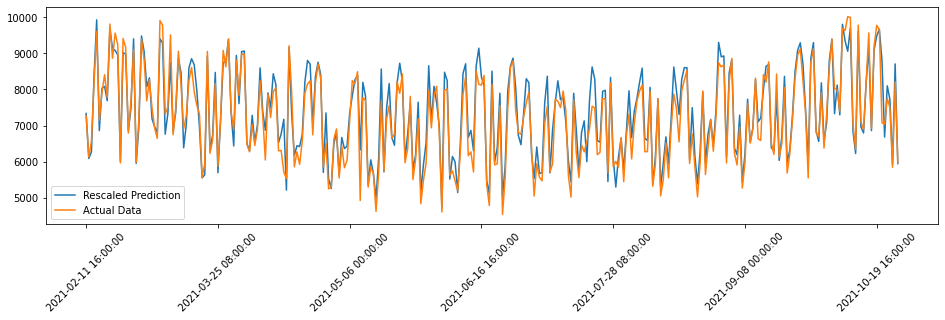

In [35]:
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    return round(mape,2) # round to 2 decimals

# rescale values based on mean and std of 'Load' column
plot_actual_r = [ x*std+mean for x in plot_actual]
plot_pred_r = [ x*std+mean for x in plot_pred]

# calculate MAPE
# mape_value = mean_absolute_percentage_error(plot_actual, plot_pred)
mape_value = mape(plot_actual_r,plot_pred_r)

print(f"Mean Absolute Percentage Error (MAPE): {mape_value} %")

# Get dates for plotting (test_data)
datesx = list(df_backup[df_backup['year'] == 2021]['Date'])

# And finally we can see that our network has done a decent job of estimating!
fig, ax = plt.subplots(figsize=(16,4))

# convert list of lists to list (np.hstack)
# get every N-th value of predicion and data list and display them in common plot
N = 1000
ax.plot(plot_pred_r[::N], label='Rescaled Prediction')
ax.plot(plot_actual_r[::N], label='Actual Data')
ax.set_xticklabels(datesx[::N], rotation=45)
ax.legend();

Mean Absolute Percentage Error (MAPE): 4.67 %


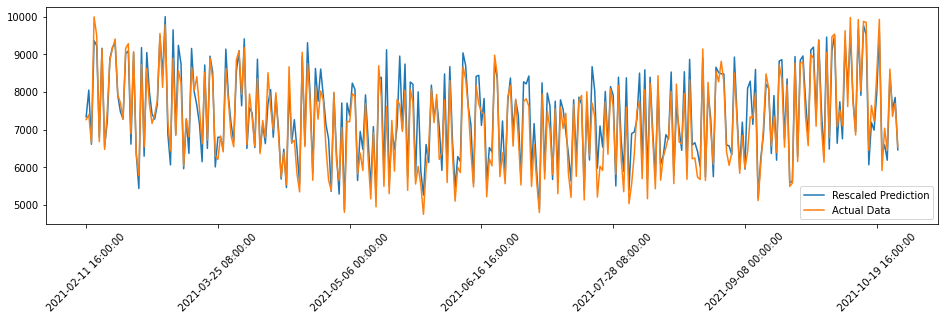

In [11]:
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    return round(mape,2) # round to 2 decimals

# rescale values based on mean and std of 'Load' column
plot_actual_r = [ x*std+mean for x in plot_actual]
plot_pred_r = [ x*std+mean for x in plot_pred]

# calculate MAPE
# mape_value = mean_absolute_percentage_error(plot_actual, plot_pred)
mape_value = mape(plot_actual_r,plot_pred_r)

print(f"Mean Absolute Percentage Error (MAPE): {mape_value} %")

# Get dates for plotting (test_data)
datesx = list(df_backup[df_backup['year'] == 2021]['Date'])

# And finally we can see that our network has done a decent job of estimating!
fig, ax = plt.subplots(figsize=(16,4))

# convert list of lists to list (np.hstack)
# get every N-th value of predicion and data list and display them in common plot
N = 1000
ax.plot(plot_pred_r[::N], label='Rescaled Prediction')
ax.plot(plot_actual_r[::N], label='Actual Data')
ax.set_xticklabels(datesx[::N], rotation=45)
ax.legend();

In [12]:
# The tensorboard logger is pretty nifty too!
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 5032), started 2 days, 6:13:20 ago. (Use '!kill 5032' to kill it.)

In [13]:
# # replace countries with a unique integer based on country_dict
# country_dict = {}
# for idx,country in enumerate(df['country'].unique()): country_dict[country] = idx
# df.replace({"country": country_dict}, inplace=True)

# # drop columns that do not contain numbers
# # (since dataframe is editted to have a freq of 1hour, minute/second column is useless)
# fields_to_drop = ['datetime', 'Date', 'timestamp', 'WN','minute','second']
# df.drop(fields_to_drop, axis=1, inplace = True, errors='ignore')

# #replace boolean true/false with 1/0
# df[['weekend','holiday']] = df[['weekend','holiday']].replace({True: 1, False: 0})

In [14]:
class MyTimeSeriesDataset(Dataset):
    def __init__(self, df, lookback_window, forecast_horizon):
        self.l_window = lookback_window
        self.f_horizon = forecast_horizon
        
        # Reset "Unnamed: 0" based on shape of df it is in 
        df['Unnamed: 0'] = range(1, len(df) + 1)
        df_new = df.copy()    
        self.dataset = df_new

        for inc in range(0,int(lookback_window)):
            df_new['feauture_' + str(inc)] = df_new['Load'].shift(-inc)
        
        # shift 'load' column permanently for as many shifts happened at 'lookback_window' loops  
        df_new['Load'] = df_new['Load'].shift(-int(lookback_window))
        
        for inc in range(0,int(forecast_horizon)):
            df_new['target_' + str(inc)] = df_new['Load'].shift(-inc)
        
        # drop lines that have NaN and reset indexing of csv file
        df_new = df_new.dropna().reset_index(drop=True)    
        
        # drop first two columns ('Unnamed: 0','Load') of dataframe
        df_new = df_new.iloc[: , 2:]        
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input = self.dataset.iloc[:,:self.l_window] 
        output = self.dataset.iloc[:,-self.f_horizon:]
        return input,output


lookback_window = 5
forecast_horizon = 3    
trainLoader = DataLoader(MyTimeSeriesDataset(train_data,lookback_window,forecast_horizon))
valLoader = DataLoader(MyTimeSeriesDataset(validation_data,lookback_window,forecast_horizon))
testLoader = DataLoader(MyTimeSeriesDataset(test_data,lookback_window,forecast_horizon))